# Lab Assignment Five: Wide and Deep Network Architectures
In this lab, you will select a prediction task to perform on your dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

### Dataset Selection

Select a dataset similarly to lab one. That is, the dataset must be table data and must have categorical features. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification, multi-class classification, or regression. You are NOT allowed to use the census (i.e., Adult) dataset that was given as an example in class. Be sure to provide a link or citation to your chosen dataset.

Dataset:
- https://www.kaggle.com/datasets/mysarahmadbhat/mercedes-used-car-listing

# **1. Preparation**

## **1.1 Defining & Preparing Class Variables**

In [ ]:
# Importing packages
import numpy as np
import pandas as pd
import missingno as mn
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Scikit-Learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_rel, wilcoxon


# Tensorflow Keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('../../Data/merc.csv')
df.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0
5,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2
6,GLE Class,2018,30948,Automatic,16000,Diesel,145,47.9,2.1
7,S Class,2012,10948,Automatic,107000,Petrol,265,36.7,3.5
8,G Class,2019,139948,Automatic,12000,Petrol,145,21.4,4.0
9,GLA Class,2017,19750,Automatic,15258,Diesel,30,64.2,2.1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13119 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         13119 non-null  object 
 1   year          13119 non-null  int64  
 2   price         13119 non-null  int64  
 3   transmission  13119 non-null  object 
 4   mileage       13119 non-null  int64  
 5   fuelType      13119 non-null  object 
 6   tax           13119 non-null  int64  
 7   mpg           13119 non-null  float64
 8   engineSize    13119 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 922.6+ KB


In [4]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000
mean,2017.296288,24698.596920,21949.559037,129.972178,55.155843,2.071530
std,2.224709,11842.675542,21176.512267,65.260286,15.220082,0.572426
min,1970.000000,650.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,17450.000000,6097.500000,125.000000,45.600000,1.800000
50%,2018.000000,22480.000000,15189.000000,145.000000,56.500000,2.000000
75%,2019.000000,28980.000000,31779.500000,145.000000,64.200000,2.100000
max,2020.000000,159999.000000,259000.000000,580.000000,217.300000,6.200000


In [5]:
# Returns the dimensions of the dataframe as (number of rows, number of columns)
df.shape

(13119, 9)

In [6]:
# Returns an index object containing the col labels of the dataframe
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [7]:
# Clean column names: make them lowercase and replace spaces with underscores
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

# Check the updated column names
print(df.columns)

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'tax',
       'mpg', 'engine_size'],
      dtype='object')


### Checking for Duplicate Values

In [8]:
# Checking for duplicates
duplicates_before = df.duplicated().sum()
print(f'Duplicates before dropping: {duplicates_before}')

Duplicates before dropping: 259


In [9]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [10]:
# No more duplicates!
duplicates_after = df.duplicated().sum()
print(f'Duplicates after dropping: {duplicates_after}')

Duplicates after dropping: 0


### Checking for Missing/Null Values

<Axes: >

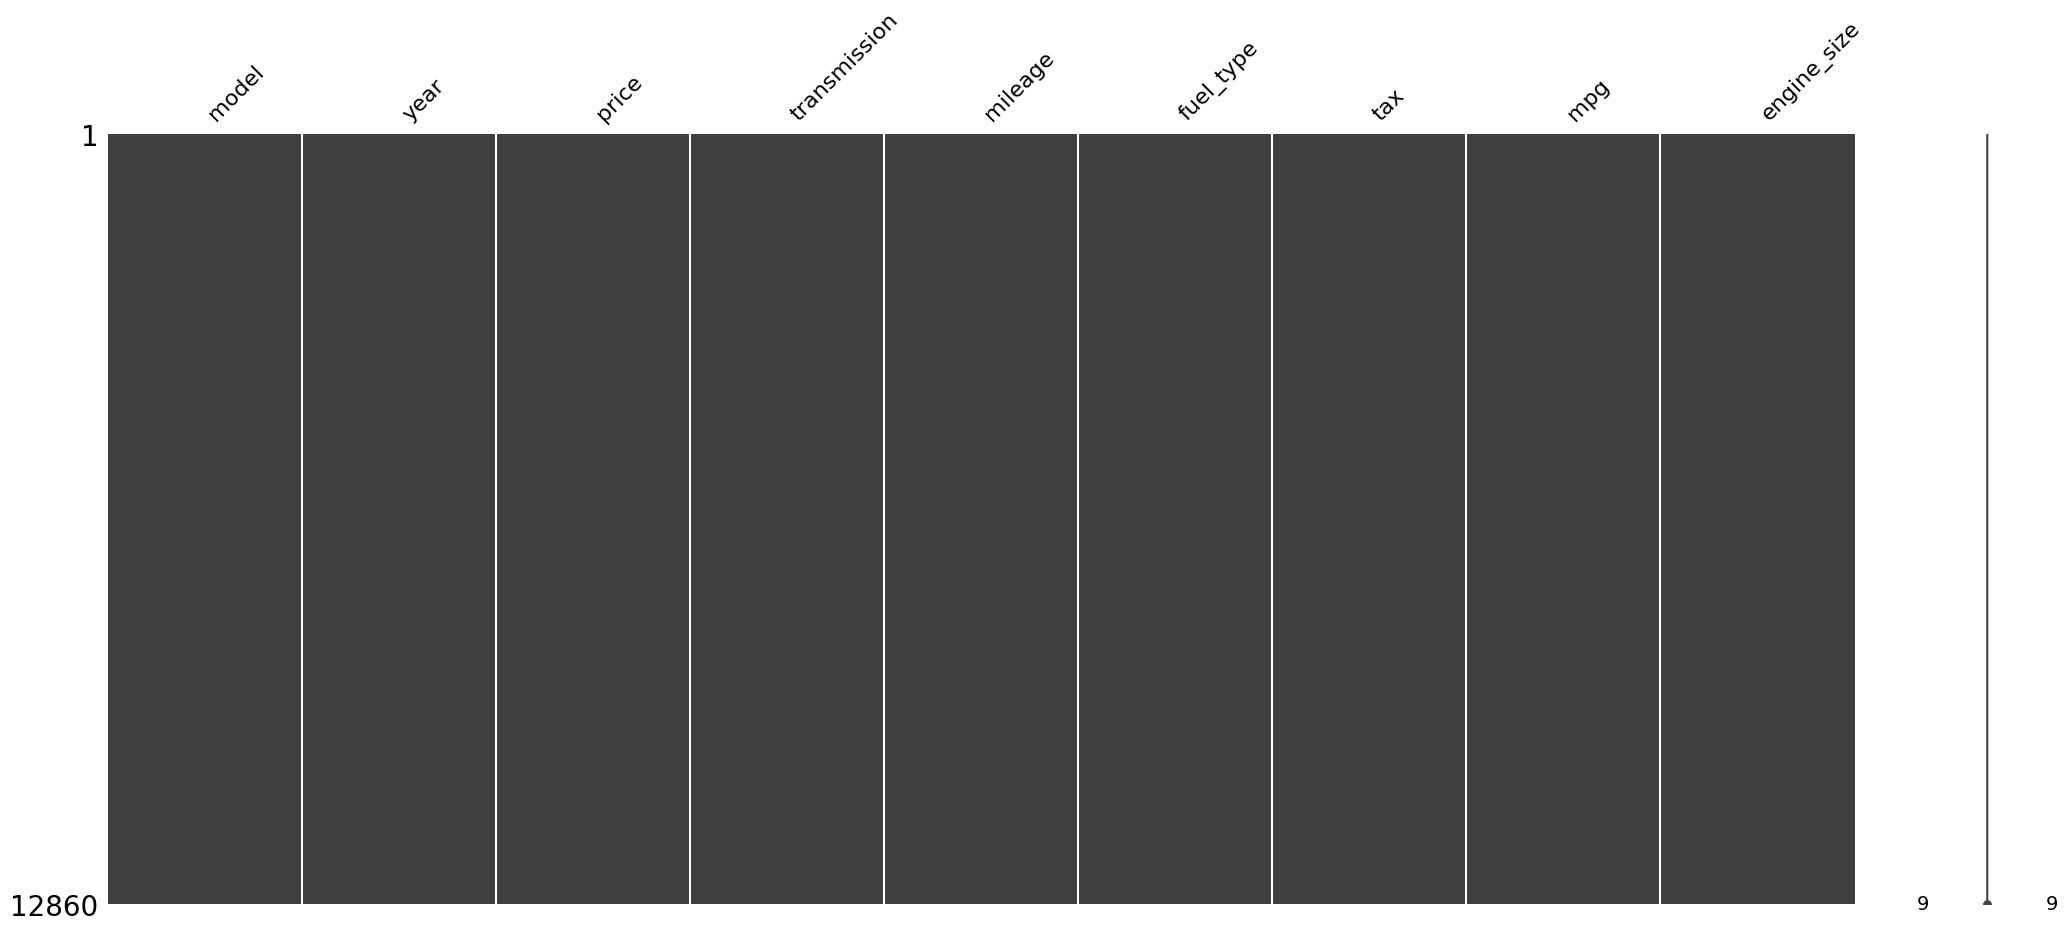

In [11]:
# Show missing data
mn.matrix(df)

In [12]:
# Checking for null values
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuel_type       0
tax             0
mpg             0
engine_size     0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12860 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         12860 non-null  object 
 1   year          12860 non-null  int64  
 2   price         12860 non-null  int64  
 3   transmission  12860 non-null  object 
 4   mileage       12860 non-null  int64  
 5   fuel_type     12860 non-null  object 
 6   tax           12860 non-null  int64  
 7   mpg           12860 non-null  float64
 8   engine_size   12860 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1004.7+ KB


### Checking for Outliers

In [14]:
# Checking For Outliers
df.describe()

,year,price,mileage,tax,mpg,engine_size
count,12860.000000,12860.000000,12860.000000,12860.000000,12860.000000,12860.000000
mean,2017.267963,24636.426361,22169.588336,129.843701,55.197535,2.075381
std,2.226127,11874.220447,21077.039295,65.580514,15.181133,0.573434
min,1970.000000,650.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,17309.750000,6494.000000,125.000000,45.600000,1.800000
50%,2018.000000,22299.000000,15448.500000,145.000000,56.500000,2.000000
75%,2019.000000,28971.250000,32000.000000,145.000000,64.200000,2.100000
max,2020.000000,159999.000000,259000.000000,580.000000,217.300000,6.200000


In [15]:
# Defines upper and lower bounds for each column
df = df[
    (df['price'] >= 1000) & (df['price'] <= 60000) &         # Filter price between 1,000 and 60,000
    (df['mileage'] <= 150000) &                              # Filter mileage below 150,000
    (df['tax'] <= 300) &                                     # Filter tax below 300
    (df['mpg'] >= 10) & (df['mpg'] <= 100) &                 # Filter mpg between 10 and 100
    (df['engine_size'] > 0) & (df['engine_size'] <= 5)         # Filter engineSize between 0 and 5 liters
]

In [16]:
# Outliers Removed!
df.describe()

,year,price,mileage,tax,mpg,engine_size
count,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000
mean,2017.353494,23891.015707,21743.589507,126.171160,55.067776,2.027107
std,1.953895,9455.640104,19996.533334,54.209434,11.558749,0.463277
min,1997.000000,1350.000000,1.000000,0.000000,24.600000,1.300000
25%,2016.000000,17299.000000,6620.500000,125.000000,46.300000,1.600000
50%,2018.000000,22156.000000,15329.000000,145.000000,56.500000,2.000000
75%,2019.000000,28480.000000,31549.000000,145.000000,64.200000,2.100000
max,2020.000000,59999.000000,150000.000000,300.000000,80.700000,4.700000


### Evaluation of Filtering Criteria

**Objective**: The goal of the filtering criteria is to eliminate outliers that could skew the analysis and predictive modeling of car prices based on various attributes, such as price, mileage, and engine size.

#### 1. **Price Filter**: 
   - **Criteria**: Price is filtered between €1,000 and €60,000.
   - **Rationale**: 
     - **Lower Bound**: Setting a minimum price of €1,000 helps exclude listings that may be erroneous (e.g., missing data or extreme discounts).
     - **Upper Bound**: The maximum price of €60,000 is aimed at excluding luxury and exotic cars that may not represent the typical market for used Mercedes vehicles. The mean price post-filtering is €23,891, indicating that the filtered dataset contains more reasonably priced vehicles.

#### 2. **Mileage Filter**: 
   - **Criteria**: Mileage is capped at 150,000 km.
   - **Rationale**: 
     - High mileage often indicates extensive use and potential wear, which could correlate negatively with price. By limiting mileage to a maximum of 150,000 km, the dataset now represents vehicles that are more commonly sold in the used car market, improving the relevance of the data for predictive modeling. The mean mileage remains within a practical range (21,743 km).

#### 3. **Tax Filter**: 
   - **Criteria**: Tax is limited to a maximum of €300.
   - **Rationale**: 
     - This upper bound ensures that extremely high taxes, which might apply to specialty vehicles or those with high emissions, are excluded. The average tax remains reasonable at €126, supporting the filtering effectiveness.

#### 4. **MPG Filter**: 
   - **Criteria**: MPG is filtered between 10 and 100.
   - **Rationale**: 
     - Setting a minimum of 10 MPG avoids extremely inefficient vehicles that may not be practical for buyers. The maximum of 100 MPG is a logical upper limit, as cars with exceptionally high MPG are often hybrids or very efficient models that may skew predictions. The mean MPG of 55.07 suggests that the dataset retains efficient vehicles.

#### 5. **Engine Size Filter**: 
   - **Criteria**: Engine size is limited to between 0 and 5 liters.
   - **Rationale**: 
     - This range encompasses the vast majority of passenger vehicles while excluding high-performance or commercial vehicles that fall outside the typical used car market. The mean engine size of 2.03 liters is consistent with average passenger vehicles.

### Conclusion

The filtering criteria employed appear to be effective in removing outliers and retaining a dataset that is representative of the used car market. The adjustments made through these criteria led to a more focused dataset, evidenced by reasonable means and ranges for each variable.


In [17]:
# Resetting the index
df = df.reset_index(drop=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12351 entries, 0 to 12350
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         12351 non-null  object 
 1   year          12351 non-null  int64  
 2   price         12351 non-null  int64  
 3   transmission  12351 non-null  object 
 4   mileage       12351 non-null  int64  
 5   fuel_type     12351 non-null  object 
 6   tax           12351 non-null  int64  
 7   mpg           12351 non-null  float64
 8   engine_size   12351 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 868.6+ KB


### Visualizations for Categorical Attributes

#### Transmission

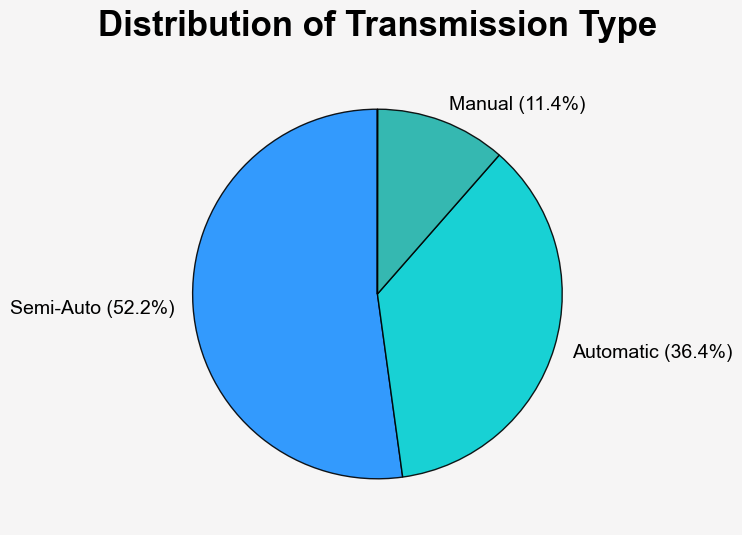

In [19]:
# Set a Seaborn style
sns.set(style="whitegrid")

# Define colors
colors = ['#1E90FF', '#00CED1', '#20B2AA', '#3CB371', '#4682B4', '#5F9EA0', '#87CEEB', '#00BFFF']
transmission_counts = df.transmission.value_counts()

# Filter out categories with zero counts (if any)
transmission_counts = transmission_counts[transmission_counts > 0]

# Calculate percentages
percentages = 100 * transmission_counts / transmission_counts.sum()

# Create labels with percentages, hiding those below 1%
labels = []
for label, pct in zip(transmission_counts.index, percentages):
    if pct < 1:
        labels.append("")  # Set empty for small percentages
    else:
        labels.append(f"{label} ({pct:.1f}%)")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the pie chart
wedges, texts = ax.pie(transmission_counts, 
                        labels=labels, 
                        startangle=90, 
                        colors=colors[:len(transmission_counts)],
                        wedgeprops=dict(edgecolor='black', alpha=0.9))

# Style the text labels
for text in texts:
    text.set_fontsize(14)
    text.set_color('black')

# Set the title
plt.title('Distribution of Transmission Type', fontsize=25, fontweight='bold', color='black', pad=20)

# Optional: Customize the figure background color
fig.patch.set_facecolor('#f6f5f5')

# Display the pie chart
plt.show()

#### Model

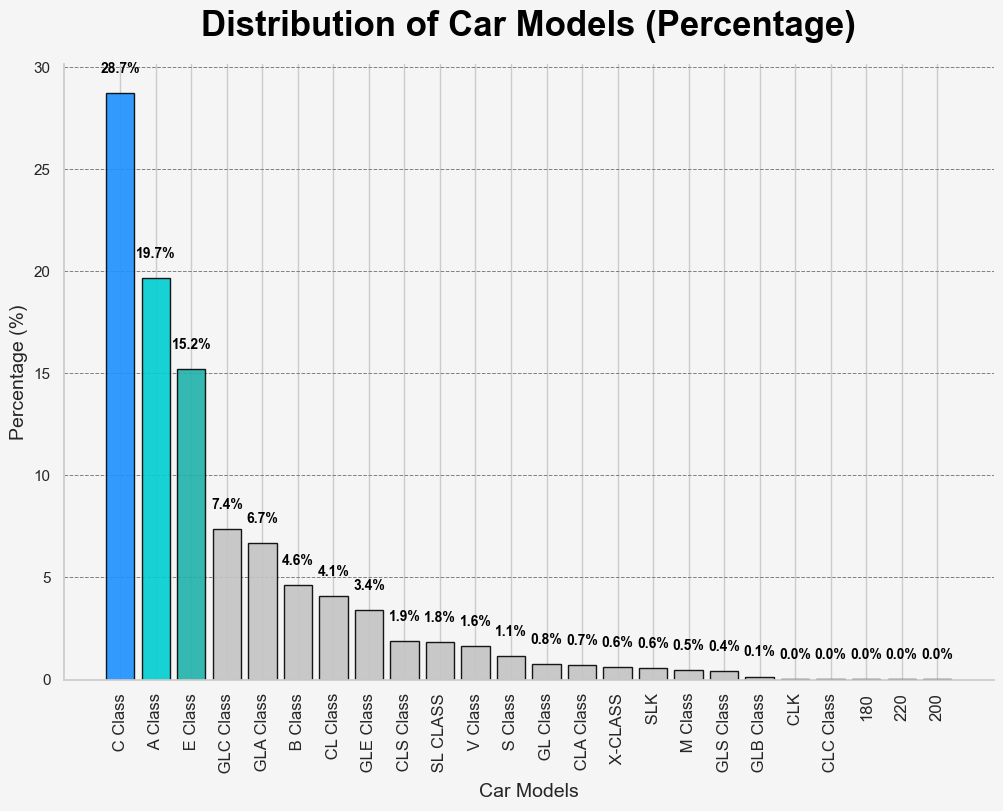

In [20]:
# Set a Seaborn style
sns.set(style="whitegrid")

# Get counts for all models
model_counts = df.model.value_counts()
total_counts = model_counts.sum()

# Calculate percentages
percentages = (model_counts / total_counts) * 100

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Determine colors: unique colors for the top three percentages, grey for the rest
colors = ['#1E90FF', '#00CED1', '#20B2AA']  # Distinct colors for the top three
grey_color = '#c4c4c4'  # Grey for the rest
bar_colors = [grey_color] * len(percentages)

# Get indices of the top three models
top_three_indices = percentages.nlargest(3).index
for i in range(len(percentages)):
    if percentages.index[i] in top_three_indices:
        bar_colors[i] = colors.pop(0)  # Assign a distinct color

# Create vertical bars
bars = ax.bar(percentages.index, percentages.values, color=bar_colors, alpha=0.9, edgecolor='black')

# Add annotations for the percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', 
            ha='center', fontsize=10, fontweight='bold', color='black')  # Set fontsize to 10

# Set the title
plt.title('Distribution of Car Models (Percentage)', fontsize=25, fontweight='bold', color='black', pad=20)

# Customize the axes
ax.set_xlabel('Car Models', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)

# Rotate x-tick labels to vertical for better alignment
plt.xticks(rotation=90, ha='center', fontsize=12)  # Set rotation to 90 for vertical

# Optional: Customize the figure background color
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

# Add gridlines for better readability
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray')

# Hide the spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#### Engine Size

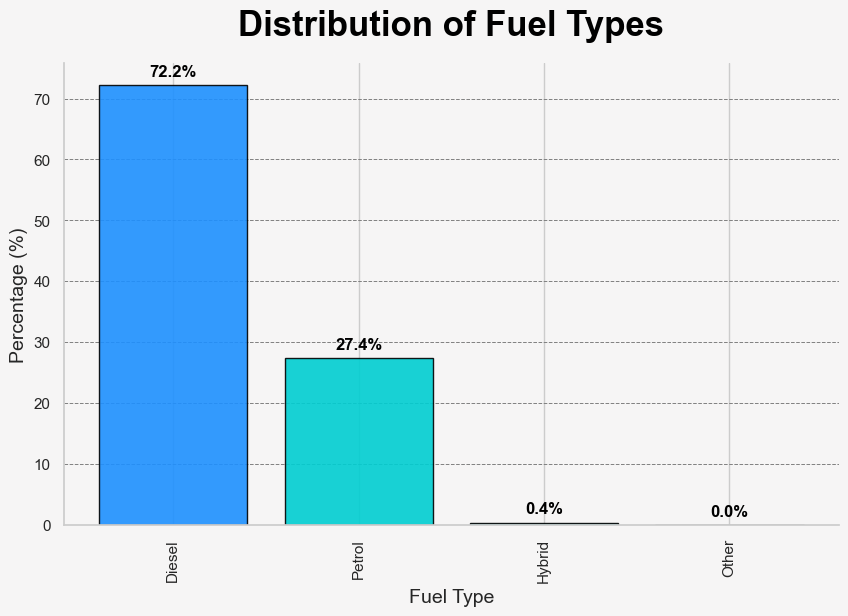

In [21]:
# Set a Seaborn style
sns.set(style="whitegrid")

# Define a cooler color palette
colors = ['#1E90FF', '#00CED1', '#20B2AA'] + ['#c4c4c4'] * 5  # Grey for the rest

# Get counts for fuel types
fuel_counts = df.fuel_type.value_counts()

# Calculate percentages
fuel_percentages = (fuel_counts / fuel_counts.sum()) * 100

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create vertical bars
bars = ax.bar(fuel_percentages.index, fuel_percentages.values, color=colors[:len(fuel_percentages)], alpha=0.9, edgecolor='black')

# Add annotations for the percentage labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', 
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Set the title
plt.title('Distribution of Fuel Types', fontsize=25, fontweight='bold', color='black', pad=20)

# Customize the x and y axis
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xlabel('Fuel Type', fontsize=14)

# Optional: Customize the figure background color
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

# Add gridlines for better readability
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray')

# Hide the spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate the x labels to be vertical
plt.xticks(rotation=90)

plt.show()

### Visualizations for Numerical Attributes

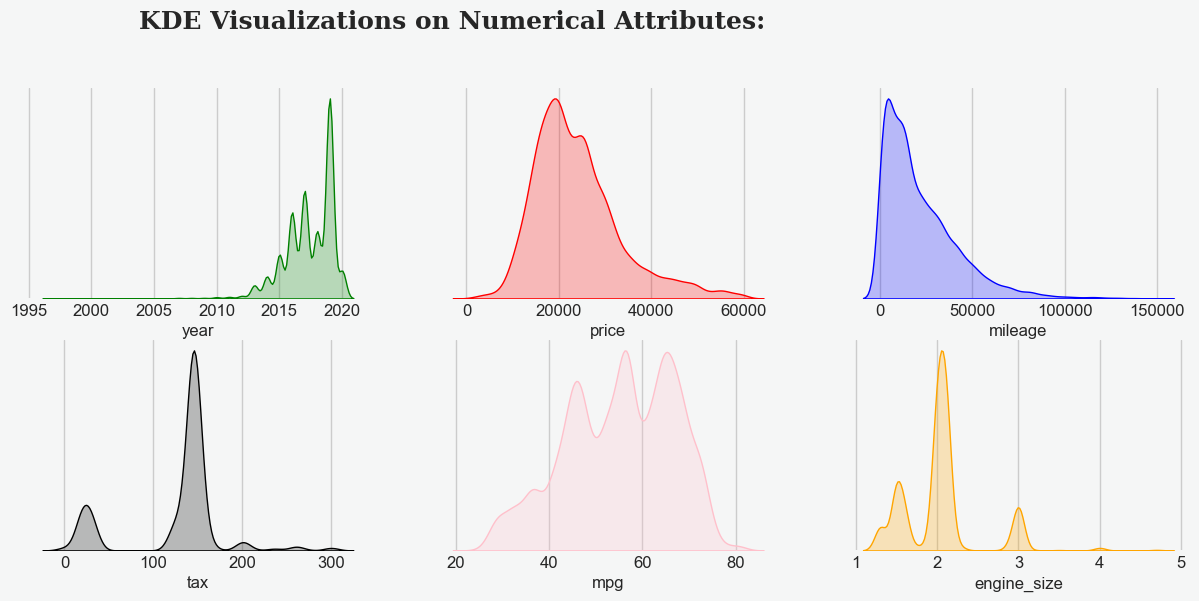

In [22]:
# Set up the figure
fig = plt.figure(figsize=(15, 6))
fig.patch.set_facecolor('#f5f6f6')

# Create a grid for the subplots
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.2)

# Create subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

axes = [ax0, ax1, ax2, ax3, ax4, ax5]
for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.tick_params(axis='x', labelsize=12, which='major', direction='out', pad=2, length=1.5)
    ax.tick_params(axis='y', colors='black')
    ax.axes.get_yaxis().set_visible(False)

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

# Select numerical columns
cols = df.select_dtypes(exclude='object').columns

# Plot KDE for each numerical attribute
sns.kdeplot(x=df[cols[0]], color="green", fill=True, ax=ax0)
sns.kdeplot(x=df[cols[1]], color="red", fill=True, ax=ax1)
sns.kdeplot(x=df[cols[2]], color="blue", fill=True, ax=ax2)
sns.kdeplot(x=df[cols[3]], color="black", fill=True, ax=ax3)
sns.kdeplot(x=df[cols[4]], color="pink", fill=True, ax=ax4)
sns.kdeplot(x=df[cols[5]], color="orange", fill=True, ax=ax5)

# Add titles and texts
fig.text(0.2, 0.98, "KDE Visualizations on Numerical Attributes:", **{'font': 'serif', 'size': 18, 'weight': 'bold'}, alpha=1)

plt.show()

#### Preparation (4 points total)
- [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required. 


### Encoding the Target Attribute: `price`

In [23]:
# Define bins and labels
bins = [0, 10000, 20000, 30000, 40000, 50000, df['price'].max()]
labels = ['Budget', 'Affordable', 'Mid-Range', 'High-End', 'Premium', 'Luxury']

# Use pd.cut to bin the 'price' and assign categories with an explicit order
df['price'] = pd.cut(df['price'], bins=bins, labels=labels, include_lowest=True)

# Explicitly define the order of the categories
ordered_labels = pd.Categorical(df['price'], categories=labels, ordered=True)

# Assign the ordered categories back to the 'price' column
df['price'] = ordered_labels

# Now, manually encode the categories as integers
df['price_encoded'] = df['price'].cat.codes

# Check the unique values in the encoded 'price' column
print("Encoded 'price' values:")
print(df['price_encoded'].unique())

# Check the mapping of the labels to the encoded values
price_mapping = dict(zip(df['price'].cat.categories, range(len(df['price'].cat.categories))))
print("\nPrice Category Encoding Mapping:", price_mapping)


Encoded 'price' values:
[3 1 2 5 0 4]

Price Category Encoding Mapping: {'Budget': 0, 'Affordable': 1, 'Mid-Range': 2, 'High-End': 3, 'Premium': 4, 'Luxury': 5}


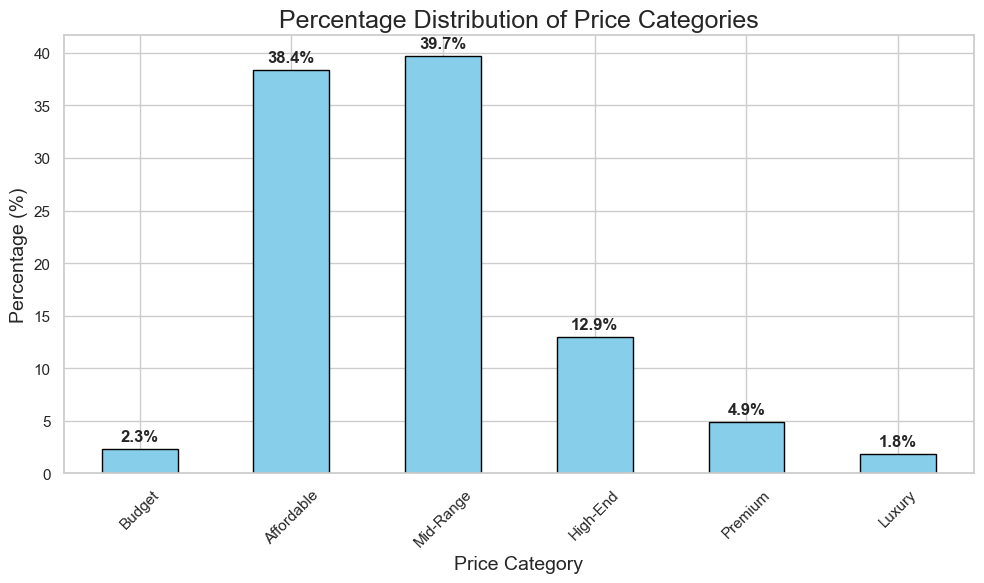

In [24]:
# Get the counts of the encoded 'price' values
price_category_counts = df['price_encoded'].value_counts(normalize=True) * 100  # Normalize to get percentages

# Get the labels corresponding to the numeric encoding
price_labels = df['price'].cat.categories  # Get the price categories

# Sort the price_category_counts so it matches the order of price_labels
price_category_counts = price_category_counts.sort_index()  # Sort by index to match the category order

# Plot a bar chart
plt.figure(figsize=(10, 6))
price_category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Percentage Distribution of Price Categories', fontsize=18)
plt.xlabel('Price Category', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)

# Set the x-ticks to the correct category labels
plt.xticks(ticks=range(len(price_labels)), labels=price_labels, rotation=45)

# Show percentage values on each bar
for index, value in enumerate(price_category_counts):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()


### Encoding Categorical Attributes

#### Model

In [25]:
# Remove leading and trailing spaces from the 'model' column
df['model'] = df['model'].str.strip()

# Sort the categories alphabetically
sorted_labels = sorted(df['model'].unique())

# Create a Categorical type with sorted categories
df['model'] = pd.Categorical(df['model'], categories=sorted_labels, ordered=True)

# Encode the 'model' column
df['model_encoded'] = df['model'].cat.codes

# Check the mapping of the labels to the encoded values
model_mapping = dict(zip(df['model'].cat.categories, range(len(df['model'].cat.categories))))
print("\nModel Encoding Mapping:", model_mapping)



Model Encoding Mapping: {'180': 0, '200': 1, '220': 2, 'A Class': 3, 'B Class': 4, 'C Class': 5, 'CL Class': 6, 'CLA Class': 7, 'CLC Class': 8, 'CLK': 9, 'CLS Class': 10, 'E Class': 11, 'GL Class': 12, 'GLA Class': 13, 'GLB Class': 14, 'GLC Class': 15, 'GLE Class': 16, 'GLS Class': 17, 'M Class': 18, 'S Class': 19, 'SL CLASS': 20, 'SLK': 21, 'V Class': 22, 'X-CLASS': 23}


#### Transmission

In [26]:
# Create a Categorical type with the unique transmission values in the original order
df['transmission'] = pd.Categorical(df['transmission'], ordered=True)

# Encode the 'transmission' column
df['transmission_encoded'] = df['transmission'].cat.codes

# Check the unique encoded 'transmission' values
print("Encoded 'transmission' values:")
print(df['transmission_encoded'].unique())

# Check the mapping of the labels to the encoded values
transmission_mapping = dict(zip(df['transmission'].cat.categories, range(len(df['transmission'].cat.categories))))
print("\nTransmission Encoding Mapping:", transmission_mapping)


Encoded 'transmission' values:
[0 1 3 2]

Transmission Encoding Mapping: {'Automatic': 0, 'Manual': 1, 'Other': 2, 'Semi-Auto': 3}


#### Fuel Type

In [27]:
# Create a Categorical type with the unique fuel types in the original order
df['fuel_type'] = pd.Categorical(df['fuel_type'], ordered=True)

# Encode the 'fuel_type' column
df['fuel_type_encoded'] = df['fuel_type'].cat.codes


# Check the mapping of the labels to the encoded values
fuel_type_mapping = dict(zip(df['fuel_type'].cat.categories, range(len(df['fuel_type'].cat.categories))))
print("\nFuel Type Encoding Mapping:", fuel_type_mapping)


Fuel Type Encoding Mapping: {'Diesel': 0, 'Hybrid': 1, 'Other': 2, 'Petrol': 3}


### Encoding Numerical Attributes

#### MPG

In [28]:
# Check the range of 'mpg' values
print("Minimum mpg value:", df['mpg'].min())
print("Maximum mpg value:", df['mpg'].max())

# Define new bin edges that cover the entire range of 'mpg' values
bins = [0, 25, 35, 45, 55, 65, 75, 85]  # Adjust these based on the actual range
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Excellent', 'Top Tier']

# Create a new column in the DataFrame for the binned mpg values
df['mpg_binned'] = pd.cut(df['mpg'], bins=bins, labels=labels, right=False)

# Check the distribution after binning
print(df['mpg_binned'].value_counts(dropna=False))

# Define ordered categories and encode them
df['mpg_binned'] = pd.Categorical(df['mpg_binned'], categories=labels, ordered=True)
df['mpg_encoded'] = df['mpg_binned'].cat.codes  # -1 will appear if there are values outside the bins

# Check the unique encoded 'mpg' values and their mapping
mpg_mapping = dict(zip(df['mpg_binned'].cat.categories, range(len(df['mpg_binned'].cat.categories))))
print("\nMPG Encoding Mapping:", mpg_mapping)

# Display the encoded values distribution
print(df['mpg_encoded'].value_counts())


Minimum mpg value: 24.6
Maximum mpg value: 80.7
mpg_binned
Very High    3846
High         2953
Excellent    2869
Medium       1924
Low           674
Top Tier       83
Very Low        2
Name: count, dtype: int64

MPG Encoding Mapping: {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4, 'Excellent': 5, 'Top Tier': 6}
mpg_encoded
4    3846
3    2953
5    2869
2    1924
1     674
6      83
0       2
Name: count, dtype: int64


#### Year

In [29]:
# Define bins and labels for decades
year_bins = [1990, 2000, 2010, 2020, 2030]  # Adjusted to cover the full range of years
year_labels = ['1990s', '2000s', '2010s', '2020s']

# Create a new column in the DataFrame for the binned year values
df['year_binned'] = pd.cut(df['year'], bins=year_bins, labels=year_labels, right=False)

# Check the distribution after binning
print(df['year_binned'].value_counts(dropna=False))

# Define ordered categories and encode them
df['year_binned'] = pd.Categorical(df['year_binned'], categories=year_labels, ordered=True)
df['year_encoded'] = df['year_binned'].cat.codes  # -1 will appear if there are values outside the bins

# Check the unique encoded year values and their mapping
year_mapping = dict(zip(df['year_binned'].cat.categories, range(len(df['year_binned'].cat.categories))))
print("\nYear Encoding Mapping:", year_mapping)

# Display the encoded values distribution
print(df['year_encoded'].value_counts())


year_binned
2010s    11717
2020s      586
2000s       43
1990s        5
Name: count, dtype: int64

Year Encoding Mapping: {'1990s': 0, '2000s': 1, '2010s': 2, '2020s': 3}
year_encoded
2    11717
3      586
1       43
0        5
Name: count, dtype: int64


#### Engine Size

In [30]:
scaler = StandardScaler()
df['engine_size_scaled'] = scaler.fit_transform(df[['engine_size']])

#### Tax

In [31]:
# Adjust bin edges and labels to ensure coverage of all values
tax_bins = [0, 50, 100, 150, 250, 301]  # Adjust as needed to cover the entire range
tax_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Apply binning with adjusted bins
df['tax_binned'] = pd.cut(df['tax'], bins=tax_bins, labels=tax_labels, right=False)

# Re-encode the binned values
df['tax_binned'] = pd.Categorical(df['tax_binned'], categories=tax_labels, ordered=True)
df['tax_encoded'] = df['tax_binned'].cat.codes

# Check the unique encoded tax values and their mapping
tax_mapping = dict(zip(df['tax_binned'].cat.categories, range(len(df['tax_binned'].cat.categories))))
print("\ntax Encoding Mapping:", tax_mapping)

# Check the distribution of 'tax_encoded' after binning and encoding
print(df['tax_encoded'].value_counts())


tax Encoding Mapping: {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
tax_encoded
2    8300
0    2298
3    1499
4     254
Name: count, dtype: int64


#### Mileage

In [32]:
scaler = StandardScaler()
df['mileage_scaled'] = scaler.fit_transform(df[['mileage']])

In [33]:
# Dropping Attributes that were Encoded
df = df.drop(columns=['price', 'model', 'transmission', 'fuel_type', 'mpg', 'mpg_binned', 'year', 'year_binned', 'engine_size','tax','tax_binned', 'mileage'])

### Preprocessing Summary:

1. **Original Data**:
    - The original dataset contains a mix of categorical and numerical columns, including: `model`, `year`, `price`, `transmission`, `mileage`, `fuelType`, `tax`, `mpg`, and `engineSize`.
    - Categorical columns: `model`, `transmission`, `fuelType`.
    - Numerical columns: `price`, `mileage`, `tax`, `mpg`, `engineSize`, `year`.

2. **Transformations and Adjustments**:
    - **Encoding Categorical Variables**:
        - The `model` column was encoded using integer labels representing different car models.
        - The `transmission` column was encoded as 0 for automatic and 1 for manual transmissions.
        - The `fuelType` column was encoded with integers for different types of fuel, such as Petrol, Diesel, and Hybrid.
        - The `mpg` (miles per gallon) values were binned into categories like "Very Low", "Low", and so on, and subsequently encoded as integers for compatibility with machine learning models.
    - **Handling Numerical Features**:
        - Numerical features like `price`, `year`, `mileage`, `tax`, and `engineSize` were either binned or scaled for better use in modeling.
        - **Binning**: The `year` column was grouped into decades (e.g., 2010-2019) and encoded as numbers.
        - **Scaling**: Standard scaling was applied to `engineSize` and `mileage` due to their wide range of values.
        - **Encoding Tax**: The `tax` column was grouped into categories (e.g., "Very Low", "Low"), then encoded into numerical values.

3. **Scaled Values**:
    - For the `engine_size_scaled` feature, standard scaling was applied to `engineSize` so that it has a mean of 0 and a standard deviation of 1.
    - Similarly, `mileage` was scaled to ensure it is on the same scale as other numerical features, improving compatibility with the machine learning models.

4. **Encoded Variables**:
    - The `price_encoded` variable was created by encoding the `price` values into different ranges, such as "Low", "Medium", and "High".
    - The categorical columns (`model_encoded`, `transmission_encoded`, `fuel_type_encoded`, `mpg_encoded`, `tax_encoded`) were all encoded into numerical values for model input.


#### Preprocessed Dataframe

In [34]:
df_preprocessed = df.copy()

In [35]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12351 entries, 0 to 12350
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_encoded         12351 non-null  int8   
 1   model_encoded         12351 non-null  int8   
 2   transmission_encoded  12351 non-null  int8   
 3   fuel_type_encoded     12351 non-null  int8   
 4   mpg_encoded           12351 non-null  int8   
 5   year_encoded          12351 non-null  int8   
 6   engine_size_scaled    12351 non-null  float64
 7   tax_encoded           12351 non-null  int8   
 8   mileage_scaled        12351 non-null  float64
dtypes: float64(2), int8(7)
memory usage: 277.5 KB


In [36]:
df_preprocessed.head(10)

,price_encoded,model_encoded,transmission_encoded,fuel_type_encoded,mpg_encoded,year_encoded,engine_size_scaled,tax_encoded,mileage_scaled
0,3,19,0,1,4,2,0.157348,0,0.262877
1,3,16,0,0,3,2,0.157348,2,-0.287241
2,1,19,0,3,2,2,3.179422,4,4.263732
3,1,13,0,0,4,2,0.157348,0,-0.324349
4,3,3,0,3,2,3,-0.058514,2,-1.057105
5,2,3,0,0,4,3,-1.137826,2,-1.037401
6,2,4,0,0,4,2,-0.058514,2,-1.073509
7,1,13,0,0,4,2,0.157348,2,0.998684
8,1,4,0,0,5,2,-1.137826,3,0.154904
9,1,5,0,0,4,2,0.157348,3,0.426962


### Final Dataset for Classification:

### Data Preprocessing:
The dataset initially contained both categorical and numerical variables. The relevant features were identified, including `price`, `model`, `year`, `transmission`, `mileage`, `fuelType`, `tax`, `mpg`, and `engineSize`. Missing values were handled as necessary, and the variables were cleaned for consistency.

### Feature Engineering:
- **Target Variable Transformation**: The `price` variable was transformed into a categorical variable (`price_encoded`) through binning, grouping the prices into discrete categories (e.g., Very Low, Low, Medium, High). This transformation was done to convert the problem from regression to classification, as the goal is now to predict which price category a given car will fall into based on the other features.
- **Categorical Encoding**: Several categorical variables were encoded into numerical values for easier use in the machine learning model. `transmission` and `fuelType` were label-encoded, and `model` was also label-encoded to represent the car models numerically.
- **Numerical Transformation**: Variables such as `engineSize` and `mileage` were scaled using standard scaling to ensure all numerical features were on the same scale. Additionally, `mileage` was transformed into a new scaled variable.
- **Binning of Year**: The `year` column was binned by decades (e.g., 2000s, 2010s) to group the data into more manageable categories, reducing the influence of specific years on the model.

### Dimensionality Reduction/Feature Selection:
- **Binning of Numerical Variables**: Initially, there was consideration to bin numerical variables like `mileage`, but due to the skewed distribution, scaling was applied instead. 

### Final Dataset:
The final dataset, prepared for classification, contains transformed features such as `price_encoded`, `model_encoded`, `transmission_encoded`, `fuel_type_encoded`, and `year_encoded`. Newly created variables like `price_encoded` and `mileage_scaled` were included to provide the model with relevant information for classification. The dataset is now structured with categorical and numerical variables, all in the correct format for use in a classification model.

### Classification Approach:
Given that the target variable `price` has been transformed into discrete categories (e.g., Very Low, Low, Medium, High), the task is now a classification problem, rather than a regression. The goal is to predict which price category a car will fall into based on its features. Feature selection and preprocessing steps ensure that all variables are in the right format and scale for optimal model performance. The model will be trained to classify a given car into one of the price categories based on its characteristics, which include model, transmission type, fuel type, mileage, and others. Overall, the preprocessing steps ensured that all variables were appropriately encoded, scaled, or transformed to provide the model with clean and structured data, ready for building and training a classification model.

## **1.2 Identifying Groups for Cross-Product Features**


- [1 points] Identify groups of features in your data that should be combined into cross-product features. Provide a compelling justification for why these features should be crossed (or why some features should not be crossed). 


### Proposed Cross-Product Features and Justification:

1. **`fuel_type_encoded` × `mpg_encoded`**
   - **Justification:** The relationship between fuel type and MPG can provide useful insights into how different fuel types (e.g., Diesel, Petrol) correlate with fuel efficiency. For example, Diesel and Hybrid cars tend to have higher MPG compared to Petrol cars. By crossing these features, we capture the potential interactions between fuel type and MPG that might not be apparent when these features are treated separately.
   - **Mapped Values:**
     - **Fuel Type Encoding Mapping:**
       - `Diesel`: 0
       - `Hybrid`: 1
       - `Other`: 2
       - `Petrol`: 3
     - **MPG Encoding Mapping:**
       - `Very Low`: 0
       - `Low`: 1
       - `Medium`: 2
       - `High`: 3
       - `Very High`: 4
       - `Excellent`: 5
       - `Top Tier`: 6
   - This cross-product feature can help in identifying patterns of high MPG for specific fuel types (e.g., `Petrol` cars with `Excellent` or `Very High` MPG ratings).

2. **`transmission_encoded` × `engine_size_scaled`**
   - **Justification:** The interaction between transmission type and engine size can be a significant factor in determining the performance and efficiency of a car. `Automatic` and `Semi-Auto` transmissions tend to be paired with larger engine sizes, while `Manual` transmissions might often be associated with smaller engines. Cross-encoding these features will allow the model to better understand how engine size influences transmission type.
   - **Mapped Values:**
     - **Transmission Encoding Mapping:**
       - `Automatic`: 0
       - `Manual`: 1
       - `Other`: 2
       - `Semi-Auto`: 3
     - **Engine Size Scaling:** The scaled `engine_size` helps the model understand the size relative to the dataset, so crossing this with the `transmission` type can reveal trends in car configurations (e.g., larger engines tend to be automatic).
   - This interaction captures nuances in how engine size and transmission type work together in shaping the vehicle's overall performance and efficiency.

3. **`year_encoded` × `mileage_scaled`**
   - **Justification:** The age of the car (represented by the `year`) and its mileage are often related. Older cars typically have higher mileage, and understanding this relationship could provide insights into car depreciation or potential maintenance needs. By crossing these features, we capture the interaction between the car's age and its condition (in terms of mileage), which could influence its pricing and desirability.
   - **Mapped Values:**
     - **Year Encoding Mapping:**
       - `1990s`: 0
       - `2000s`: 1
       - `2010s`: 2
       - `2020s`: 3
     - **Mileage Scaling:** `Mileage` is scaled to understand its relative effect on the overall condition of the vehicle, with lower mileage indicating better condition. Crossing this with the `year` of manufacture allows the model to better grasp how mileage patterns change over time.
   - This cross-product can reveal trends, like how high mileage negatively affects older cars or how newer cars with high mileage might still be considered in good condition.

4. **`model_encoded` × `year_encoded`**
   - **Justification:** Different car models tend to have different lifespans, and older models often have different features or designs compared to newer ones. By crossing `model` type with `year`, we can capture how the car's `model` influences its age-related features, such as depreciation or technological advancements.
   - **Mapped Values:**
     - **Model Encoding Mapping:** Each `model` is mapped to an integer (e.g., `180` to 0, `200` to 1, etc.), which helps the model distinguish between different vehicle models.
     - **Year Encoding Mapping:** The model’s release `year` can interact with the specific features of that `model`, highlighting how older models perform or are valued differently than newer models like the 1990s vehicles.
   - This interaction could reveal interesting patterns, such as newer models (e.g., `GLA Class` or `S Class`) holding their value better than older models like the 1990s vehicles.

### Why the Target Variable Should Not Be Included:
- **Target Variable (e.g., `price_encoded`)**: The target variable in a classification or regression task represents the output or prediction that the model aims to predict. It should not be included in the cross-product features because:
  - **Leakage of Information**: Including the target variable in the feature set would introduce data leakage, where the model already knows the outcome while training, leading to an unrealistic and over-optimistic evaluation of its performance.
  - **Redundancy**: The target variable is what the model is trying to predict, so it should not be part of the input features. Including it would make the problem trivial and invalidate the prediction task.
  - **Model Integrity**: The objective is for the model to learn meaningful relationships between the features and the target variable. Including the target in the feature set would undermine this learning process by providing direct access to the target during model training.

### Conclusion:
The proposed cross-product features are meaningful because they combine variables that have logical interactions in the context of the dataset. These interactions could reveal complex patterns that would be missed if the features were used separately. Additionally, the encoded values ensure that the categorical features are handled in a way that captures the relationship between them, while the scaling of continuous features (like `engine_size` and `mileage`) ensures that their values are appropriately accounted for in the cross-products. However, the target variable should not be included as a feature to prevent data leakage and maintain the integrity of the prediction task.


In [37]:
# Cross Columns
cross_cols = [['fuel_type_encoded', 'mpg_encoded'],
              ['transmission_encoded', 'engine_size_scaled'],
              ['year_encoded', 'mileage_scaled'],
              ['model_encoded', 'year_encoded']]

cross_col_names = []
for cols_list in cross_cols:
    enc = LabelEncoder()
    
    X_crossed = df_preprocessed[cols_list].astype(str).apply(lambda x: '_'.join(x), axis=1)
    cross_col_name = '_'.join(cols_list)
    enc.fit(X_crossed)
    df_preprocessed[cross_col_name] = enc.transform(X_crossed)
    cross_col_names.append(cross_col_name) 
    
cross_col_names

['fuel_type_encoded_mpg_encoded',
 'transmission_encoded_engine_size_scaled',
 'year_encoded_mileage_scaled',
 'model_encoded_year_encoded']

## **1.3 Metrics for Evaluating Algorithm Performance**

- [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


For evaluating the performance of the classification model on the `price_encoded` target variable, the chosen metrics are **F1 Score**, **Precision**, and **Recall**. These metrics align with the business objectives and address the needs of various stakeholders. Each metric provides a different perspective on model performance, ensuring that the model accurately classifies vehicles into price categories in a way that is balanced and relevant to operational needs.

---

### F1 Score

The **F1 Score** is a metric that balances Precision and Recall, providing an overall measure of the model’s performance across different price categories. This metric is especially important for stakeholders such as sales and marketing teams, who rely on accurate vehicle segmentation to effectively target specific customer segments.

- **Business Relevance**: Sales and marketing teams need an accurate breakdown of vehicle categories—such as budget, mid-range, and premium—to tailor promotions and strategies accordingly. A high F1 Score, ideally above 0.75, would indicate that the model can effectively differentiate across all price bins, minimizing risks associated with mis-targeting. An F1 Score close to 0.80 or higher would be particularly useful, as it shows the model is well-balanced and can identify various segments without favoring one too heavily.

- **Impact**: With a balanced F1 Score, no customer segment is disproportionately ignored. This metric ensures efficient resource allocation across different categories, improving the reach and engagement of marketing campaigns.

---

### Precision

**Precision** is essential for evaluating the model’s accuracy in predicting specific price categories. High Precision helps avoid false positives, particularly for high-value categories, which is critical for stakeholders such as inventory management and customer relations.

- **Business Relevance**: Inventory and customer relations teams need the model to accurately identify high-value categories to ensure that customers are not misled by incorrect classifications of vehicles as premium when they are not. For premium bins, Precision should ideally be above 0.85 to avoid classifying lower-cost vehicles as high-value. For budget categories, a Precision score of 0.75 is acceptable, as minor overlaps may be tolerable due to higher demand.

- **Impact**: Strong Precision (above 0.85 for high-value bins) builds customer trust, as it assures that vehicles advertised as premium meet expectations. Additionally, by correctly classifying these premium vehicles, the organization can allocate them to the appropriate customer segments, reducing resource misallocation.

---

### Recall

**Recall** measures the model’s effectiveness in capturing all relevant instances within each price category, ensuring comprehensive coverage of each price range. This is valuable to market analysis and inventory planning teams, as it helps avoid missing any vehicles within high-demand segments.

- **Business Relevance**: Market analysts and inventory planners benefit from high Recall because it enables accurate demand forecasting and better inventory management. For budget bins, Recall should ideally be above 0.80 to ensure the model captures a complete view of affordable options. For luxury bins, where segments are often smaller, a slightly lower Recall of 0.75 is acceptable.

- **Impact**: High Recall across categories ensures full market visibility, helping analysts make confident assessments of demand across price segments. For inventory management, high Recall ensures that the inventory aligns well with demand across all categories, reducing the risk of stock imbalances.

---

### Summary of Metrics and Stakeholder Impact

Each metric was chosen to align with business needs and maximize operational efficiency:

- **F1 Score** provides a balanced measure, helping sales and marketing reach the right audience segments with fewer misclassifications.
- **Precision** minimizes costly errors in premium categories, enhancing customer satisfaction and resource allocation.
- **Recall** supports complete market visibility and demand forecasting, critical for market analysis and inventory planning.

Together, these metrics provide a well-rounded evaluation of model performance, ensuring that the classification of price categories supports business objectives across multiple functional areas. By meeting each metric’s threshold, the model can drive data-driven decisions, improving customer engagement and operational accuracy.


## **1.4 Dividing Data into Training & Testing**

- [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. Use the method to split your data that you argue for. 

### Method for Dividing Data: Stratified 10-Fold Cross-Validation

For dividing the data into training and testing, **Stratified 10-fold cross-validation** will be used. This method was selected due to several reasons that align with the nature of the dataset and the task at hand.

#### Choice of Method: Stratified 10-Fold Cross-Validation

Stratified 10-fold cross-validation ensures that the data is split into 10 equal parts, with each fold maintaining the same distribution of the target variable, `price_encoded`, as in the entire dataset. This is particularly important because the target variable consists of multiple price categories (bins), which could potentially be imbalanced. Some price categories might have more data points than others, and using **stratified** splits ensures that each fold has a proportional representation of each class. This way, each fold accurately represents the overall distribution of the target, preventing bias that could arise from skewed distributions in certain folds.

#### Why Stratified 10-Fold Cross-Validation Is Appropriate

1. **Handling Imbalanced Classes**:  
   The target variable, `price_encoded`, consists of different price categories, which might not have an even distribution of instances. Some price bins may be overrepresented (e.g., a popular mid-range price category), while others may have very few instances. In such cases, a standard cross-validation method could lead to some folds having few or no examples of certain price bins, resulting in biased or inaccurate model performance. Stratified cross-validation addresses this by ensuring that each fold has a similar proportion of each category, making the evaluation of the model’s performance more reliable across all price bins.

2. **More Reliable Performance Metrics**:  
   Using Stratified 10-fold cross-validation provides a more comprehensive and reliable evaluation of the model. Since each fold is tested on a different subset of the data, the model’s performance metrics, such as **F1 score**, **precision**, and **recall**, are averaged over multiple folds. This reduces the impact of any one random split that may be unrepresentative of the overall data. It also helps account for variability in the model's performance, leading to a more robust estimate of how well the model generalizes to new, unseen data.

3. **Mirroring Real-World Use**:  
   In practice, machine learning models are deployed to handle new data on an ongoing basis. Stratified 10-fold cross-validation simulates this scenario by repeatedly training and testing the model on different subsets of the data. This approach mirrors the model’s real-world application, where it would be trained on varied data points from different sources and would need to generalize well across those variations.

4. **Maximizing Data Use**:  
   Stratified 10-fold cross-validation ensures that every data point is used for both training and testing across different folds. This maximizes the use of available data, which is especially important when the dataset may be limited. In contrast, a traditional **80/20 train-test split** would set aside 20% of the data for testing, potentially reducing the amount of training data the model can use and risking a less accurate performance evaluation.

5. **Balanced and Consistent Evaluation**:  
   Stratified cross-validation helps prevent situations where a single random train-test split might not reflect the overall dataset, particularly in cases of class imbalance. This approach ensures that the model is evaluated consistently and fairly across all subsets of the data, leading to more accurate performance metrics.

#### Conclusion

Stratified 10-fold cross-validation is the most appropriate method for splitting the data in this task. It ensures that the evaluation process is representative of the target variable's distribution, leading to more accurate performance assessments. This method also reflects how an algorithm would be used in real-world scenarios, where consistent and robust model evaluation is essential. By using Stratified 10-fold cross-validation, the performance metrics—such as F1 score, precision, and recall—will be calculated more reliably, providing a true reflection of the model’s ability to generalize to unseen data.

### Splitting the Data with Stratified Fold

In [38]:
# Initialize StratifiedKFold with 10 folds
strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initializing the model
model = RandomForestClassifier(random_state=42)

# Preparing data for splits
X = df_preprocessed.drop(columns=['price_encoded'])
y = df_preprocessed['price_encoded']

# Initializing list to store the splits
splits = []

# Running cross-validation and split the data
for train_index, test_index in strat_kfold.split(X, y):
    # Stores the split data
    splits.append((X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]))

    # Checking for Successful Split
    print(f'Train set shape: {X.iloc[train_index].shape}, Test set shape: {X.iloc[test_index].shape}')
    print(f'Target distribution in training set:\n{y.iloc[train_index].value_counts(normalize=True)}')
    print(f'Target distribution in test set:\n{y.iloc[test_index].value_counts(normalize=True)}')


Train set shape: (11115, 12), Test set shape: (1236, 12)
Target distribution in training set:
price_encoded
2    0.396761
1    0.383536
3    0.129285
4    0.049033
0    0.023212
5    0.018174
Name: proportion, dtype: float64
Target distribution in test set:
price_encoded
2    0.396440
1    0.383495
3    0.129450
4    0.049353
0    0.023463
5    0.017799
Name: proportion, dtype: float64
Train set shape: (11116, 12), Test set shape: (1235, 12)
Target distribution in training set:
price_encoded
2    0.396725
1    0.383501
3    0.129273
4    0.049118
0    0.023210
5    0.018172
Name: proportion, dtype: float64
Target distribution in test set:
price_encoded
2    0.396761
1    0.383806
3    0.129555
4    0.048583
0    0.023482
5    0.017814
Name: proportion, dtype: float64
Train set shape: (11116, 12), Test set shape: (1235, 12)
Target distribution in training set:
price_encoded
2    0.396725
1    0.383501
3    0.129273
4    0.049118
0    0.023210
5    0.018172
Name: proportion, dtype: float

The cross-validation process using StratifiedKFold has been successfully implemented. The data was split into 10 folds, with each fold containing training and test sets. The training sets consistently contain around 11,115 to 11,116 samples, and the test sets have 1,235 samples. The target variable (`price_encoded`) is well-stratified, with the distribution in both the training and test sets remaining almost identical across all folds. This ensures that the target classes are proportionally represented in each fold, which helps in evaluating the model’s performance accurately. The feature sets used for training and testing contain 12 columns, matching the expected number of features. Overall, the stratified splitting process appears to be functioning correctly, ensuring a reliable cross-validation setup.

In [39]:
# Now that splits are stored, defining a function to calculate metrics
def calculate_metrics(splits):
    for fold, (X_train, X_test, y_train, y_test) in enumerate(splits, 1):
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate and print metrics
        print(f'Metrics for fold {fold}:')
        print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
        print(f'Precision: {precision_score(y_test, y_pred, average="weighted", zero_division=1)}')
        print(f'Recall: {recall_score(y_test, y_pred, average="weighted", zero_division=1)}')
        print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted", zero_division=1)}')
        print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
        print('-' * 50)

# Calls the function to calculate metrics for each split
calculate_metrics(splits)


Metrics for fold 1:
Accuracy: 0.7710355987055016
Precision: 0.7694336520357486
Recall: 0.7710355987055016
F1 Score: 0.7699011516873747
Confusion Matrix:
[[ 15  14   0   0   0   0]
 [  7 402  65   0   0   0]
 [  0  60 386  43   1   0]
 [  0   2  46  94  17   1]
 [  0   0   1  16  39   5]
 [  0   0   1   1   3  17]]
--------------------------------------------------
Metrics for fold 2:
Accuracy: 0.7740890688259109
Precision: 0.7718992985347581
Recall: 0.7740890688259109
F1 Score: 0.7722561123236487
Confusion Matrix:
[[ 17  12   0   0   0   0]
 [ 10 407  56   1   0   0]
 [  1  65 388  36   0   0]
 [  0   0  51  95  13   1]
 [  0   0   5  13  39   3]
 [  0   0   0   2  10  10]]
--------------------------------------------------
Metrics for fold 3:
Accuracy: 0.7765182186234818
Precision: 0.7779068487216326
Recall: 0.7765182186234818
F1 Score: 0.7768415453892827
Confusion Matrix:
[[ 20   8   1   0   0   0]
 [  4 397  72   1   0   0]
 [  0  55 393  40   2   0]
 [  0   0  43 101  16   0]
 [  0

# **2. Modeling**

## **2.1 Three Combined Wide & Deep Networks**

- [2 points] Create at least three combined wide and deep networks to classify your data using Keras (this total of "three" includes the model you will train in the next step of the rubric). Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations.
    - Note: you can use the "history" return parameter that is part of Keras "fit" function to easily access this data.
 


Training Combined Model 1 with crossed columns: ['fuel_type_encoded_mpg_encoded', 'transmission_encoded_engine_size_scaled']
Training fold 1 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 2 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 3 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training fold 4 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training fold 5 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 6 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 7 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training fold 8 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training fold 9 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training fold 10 for Combined Model 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training Combined Model 2 with crossed columns: ['fuel_type_encoded_mpg_encoded', 'year_encoded_mileage_scaled',

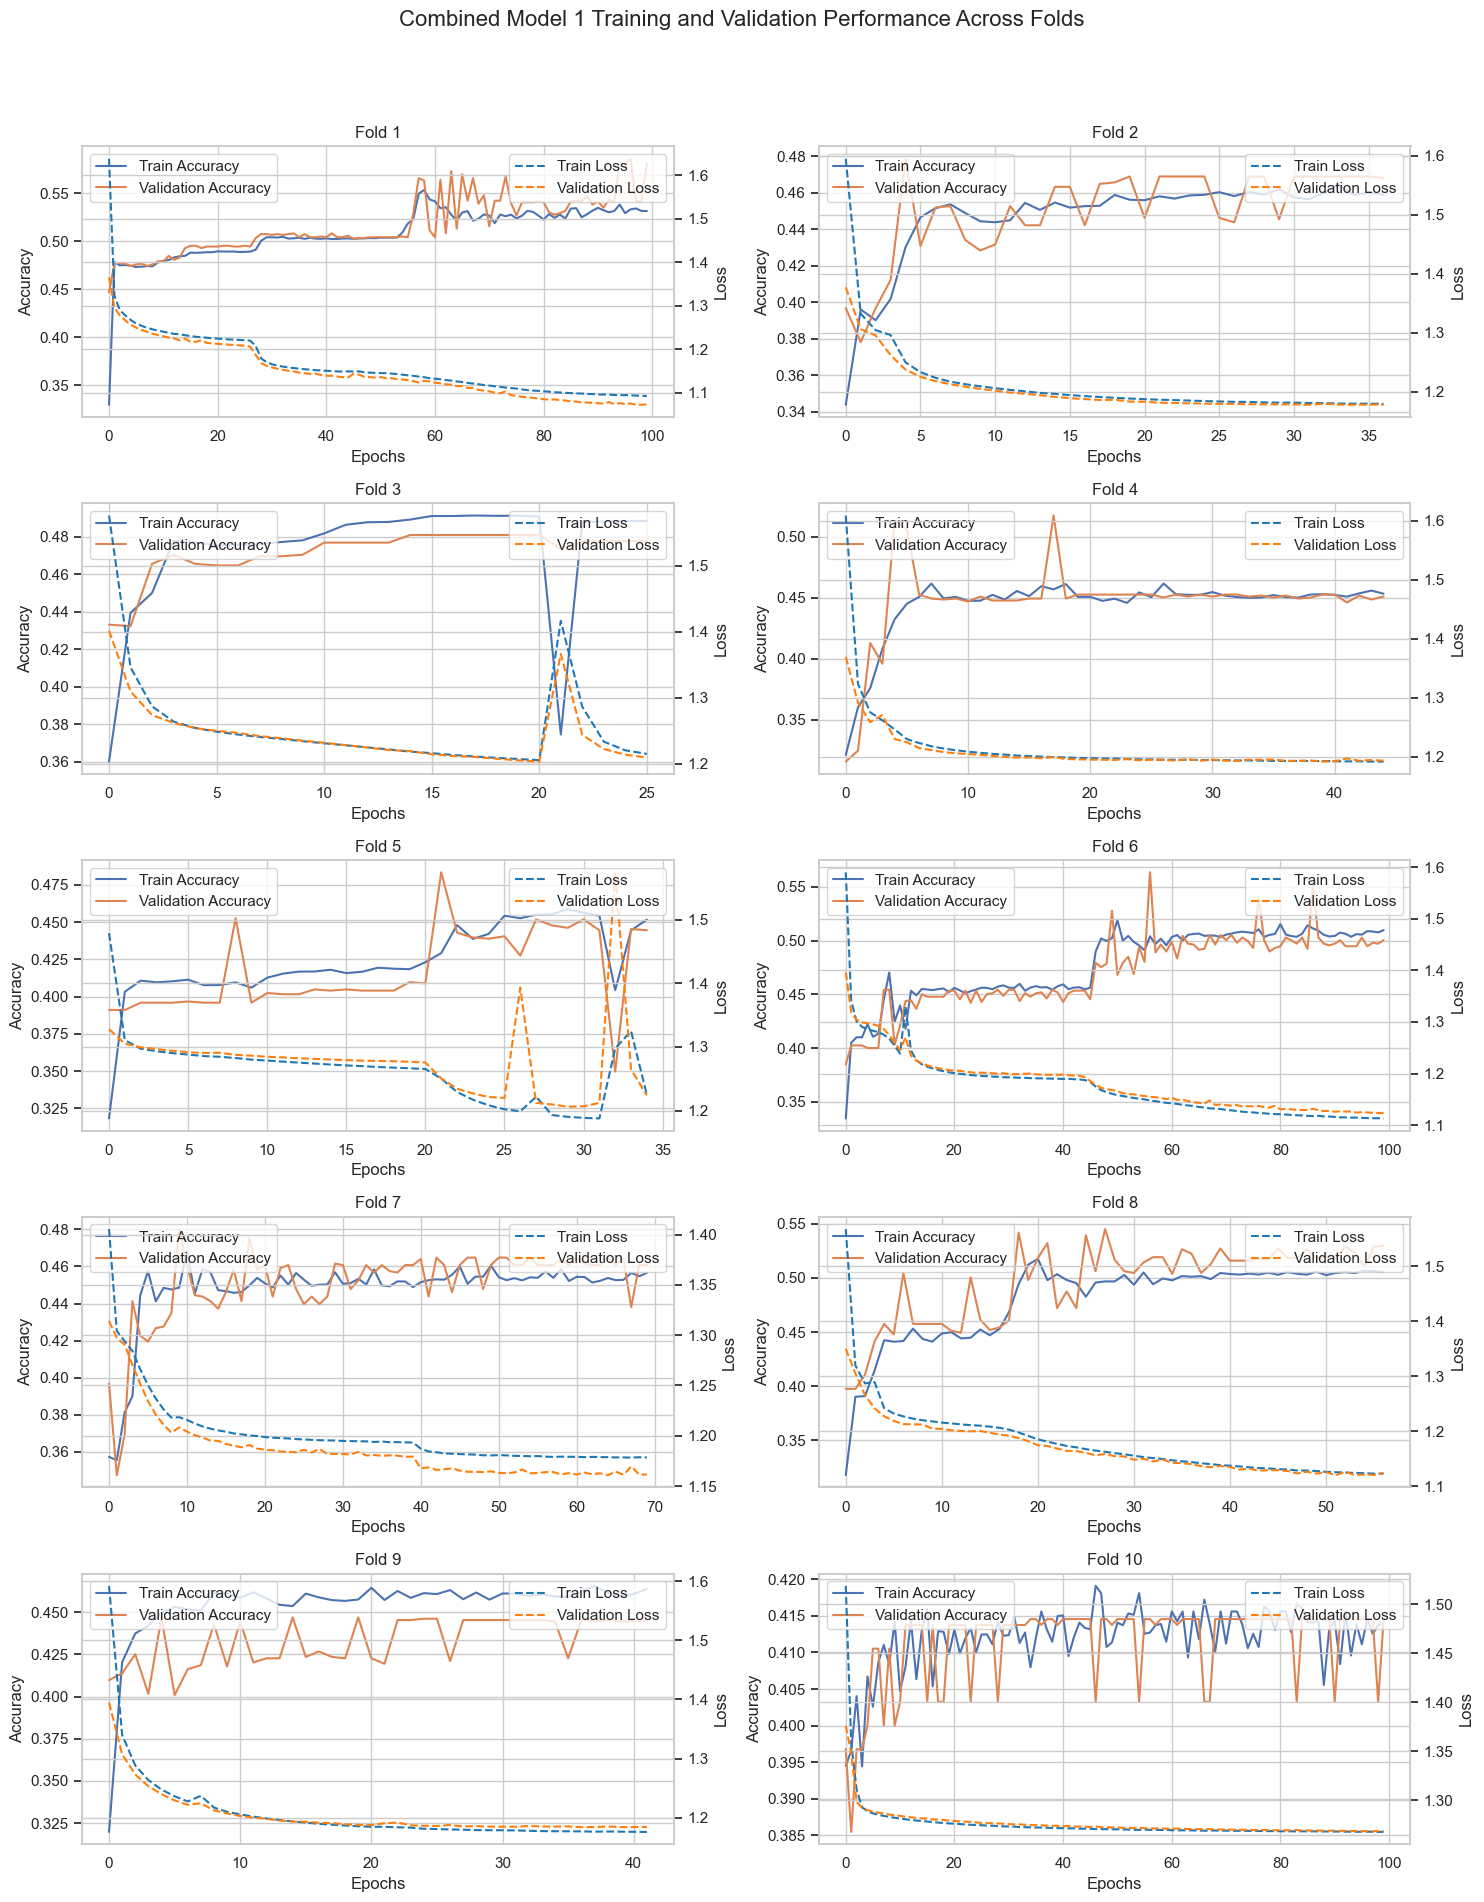

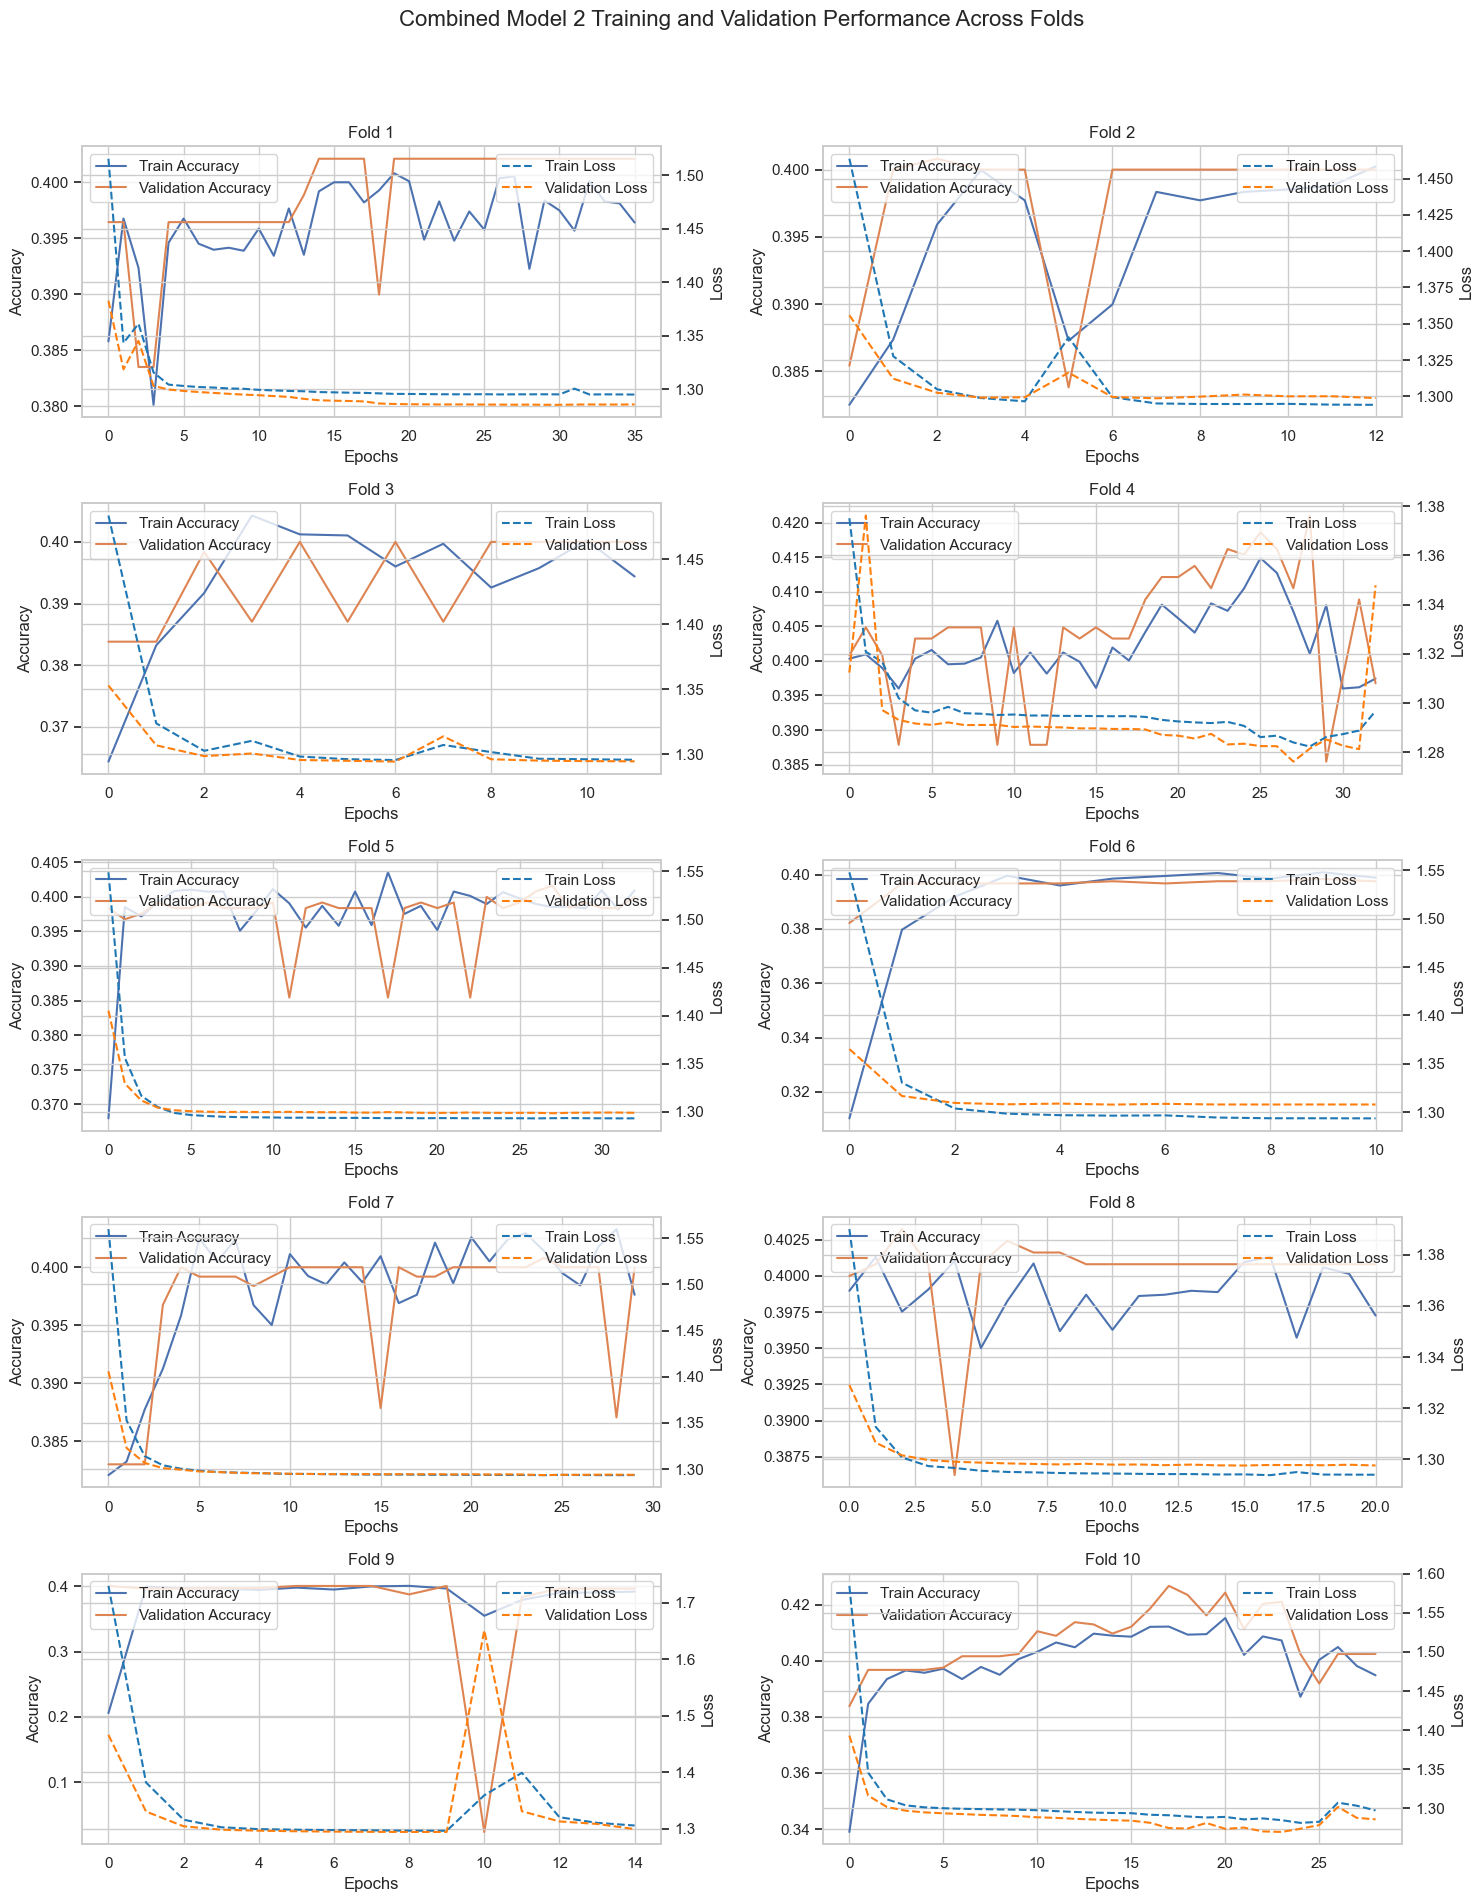

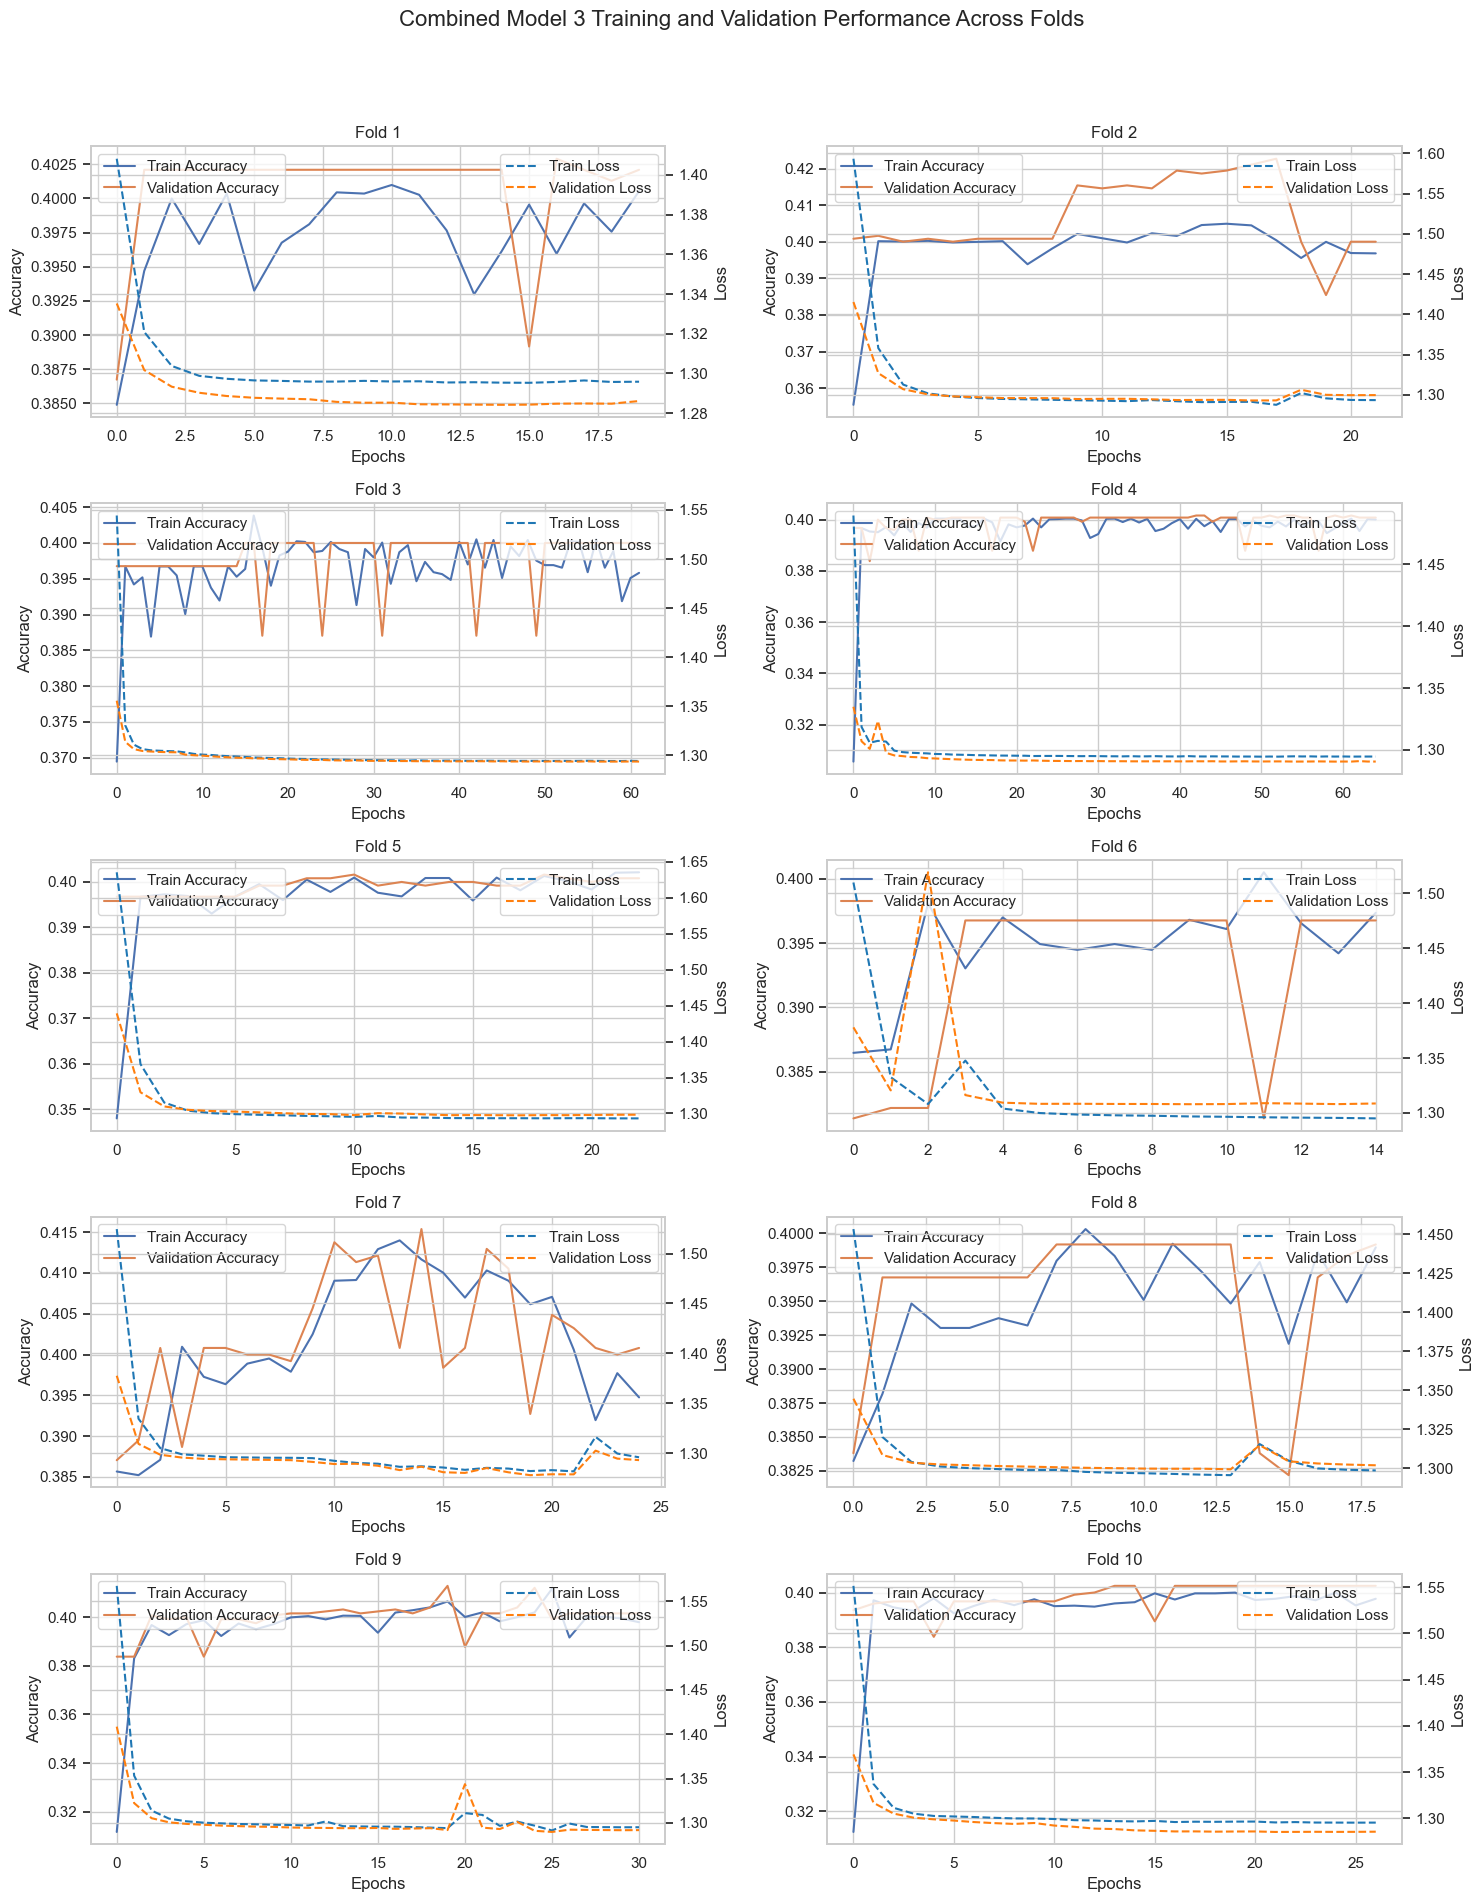

In [40]:
# Function to build a combined wide and deep model with specified crossed columns
def build_combined_model(input_shape, crossed_columns):
    # Wide branch using crossed columns
    wide_input = Input(shape=(len(crossed_columns),))
    wide_output = Dense(6, activation='softmax')(wide_input)

    # Deep branch with standard feature columns
    deep_input = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(deep_input)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    deep_output = Dense(6, activation='softmax')(x)

    # Merge wide and deep branches
    merged = concatenate([wide_output, deep_output])
    final_output = Dense(6, activation='softmax')(merged)

    model = Model(inputs=[wide_input, deep_input], outputs=final_output)
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']  # We’ll calculate precision, recall, F1 outside the model
    )
    return model

# Data Preparation
X = df_preprocessed.drop(columns=['price_encoded'])
y = df_preprocessed['price_encoded']

# Defining different combinations of crossed columns
crossed_columns_combinations = [
    ['fuel_type_encoded_mpg_encoded', 'transmission_encoded_engine_size_scaled'],  # Model 1: Two crossed columns
    ['fuel_type_encoded_mpg_encoded', 'year_encoded_mileage_scaled', 'model_encoded_year_encoded'],  # Model 2: Three crossed columns
    cross_col_names  # Model 3: All crossed columns
]

# Cross-validation setup
strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store histories and metrics for each combined model
history_combined_models = []
metrics_summary = {f'Combined Model {i+1}': [] for i in range(len(crossed_columns_combinations))}

# Train each combined model with different crossed columns
for model_idx, crossed_columns in enumerate(crossed_columns_combinations):
    print(f"\nTraining Combined Model {model_idx+1} with crossed columns: {crossed_columns}")
    
    # Prepare wide input data for the selected crossed columns
    X_wide = df_preprocessed[crossed_columns].values
    X_deep = X.values  # Deep input (all other features)
    
    # List to store histories and metrics for each fold of the current model
    history_combined = []
    fold_metrics = []

    for fold_idx, (train_index, test_index) in enumerate(strat_kfold.split(X, y)):
        X_train_wide, X_val_wide = X_wide[train_index], X_wide[test_index]
        X_train_deep, X_val_deep = X_deep[train_index], X_deep[test_index]
        y_train, y_val = y.iloc[train_index].values, y.iloc[test_index].values

        # Initialize the combined model with the current set of crossed columns
        combined_model = build_combined_model(X_train_deep.shape[1], crossed_columns)

        # Early stopping to avoid overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the combined model
        print(f"Training fold {fold_idx + 1} for Combined Model {model_idx + 1}")
        history = combined_model.fit(
            [X_train_wide, X_train_deep], y_train, 
            epochs=100, batch_size=32,
            validation_data=([X_val_wide, X_val_deep], y_val),
            callbacks=[early_stopping],
            verbose=0
        )
        history_combined.append(history)
        
        # Make predictions and calculate precision, recall, and F1-score on validation set
        y_val_pred = np.argmax(combined_model.predict([X_val_wide, X_val_deep]), axis=1)
        precision = precision_score(y_val, y_val_pred, average='weighted')
        recall = recall_score(y_val, y_val_pred, average='weighted')
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        
        # Store the metrics for this fold
        fold_metrics.append({
            'Fold': fold_idx + 1,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    # Append fold metrics and model history for visualization and reporting
    metrics_summary[f'Combined Model {model_idx+1}'] = fold_metrics
    history_combined_models.append(history_combined)

# Print summary of Precision, Recall, and F1-Score for each model
for model_name, folds in metrics_summary.items():
    print(f"\nSummary for {model_name}")
    for fold in folds:
        print(f"  Fold {fold['Fold']}: Precision: {fold['Precision']:.4f}, Recall: {fold['Recall']:.4f}, F1-Score: {fold['F1-Score']:.4f}")
    avg_precision = np.mean([f['Precision'] for f in folds])
    avg_recall = np.mean([f['Recall'] for f in folds])
    avg_f1 = np.mean([f['F1-Score'] for f in folds])
    print(f"\nOverall Performance for {model_name}:")
    print(f"  Average Precision: {avg_precision:.4f}")
    print(f"  Average Recall: {avg_recall:.4f}")
    print(f"  Average F1-Score: {avg_f1:.4f}")
    print("--------------------------------------------------")

# Visualization function for each model's training history
def plot_history(history_list, model_name):
    # Define the number of rows and columns in the grid (5 rows and 2 columns)
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
    fig.suptitle(f'{model_name} Training and Validation Performance Across Folds', fontsize=16)

    for i, history in enumerate(history_list):
        row, col = divmod(i, 2)  # Get the row and column index for the subplot
        ax = axes[row, col]

        # Plot Accuracy
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax.set_title(f'Fold {i + 1}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='upper left')
        
        # Plot Loss on a secondary y-axis
        ax2 = ax.twinx()
        ax2.plot(history.history['loss'], label='Train Loss', linestyle='--', color='tab:blue')
        ax2.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='tab:orange')
        ax2.set_ylabel('Loss')
        ax2.legend(loc='upper right')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()

# Plot training histories for each combined model
for model_idx, history in enumerate(history_combined_models):
    plot_history(history, f'Combined Model {model_idx + 1}')

#### Summary of Metrics

## **2.2 Generalization Performance**


- [2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two models (this "two" includes the wide and deep model trained from the previous step). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to answer: What model with what number of layers performs superiorly? Use proper statistical methods to compare the performance of different models.



In [41]:
# Updated function to build a combined wide and deep model with variable layers in the deep branch
def build_combined_model(input_shape, crossed_columns, deep_layers=[64, 128, 64]):
    # Wide branch using crossed columns
    wide_input = Input(shape=(4,))  # Modify this to accept 4 features
    wide_output = Dense(6, activation='softmax')(wide_input)

    # Deep branch with specified layer configuration
    deep_input = Input(shape=(input_shape,))
    x = deep_input
    for units in deep_layers:
        x = Dense(units, activation='relu')(x)
    deep_output = Dense(6, activation='softmax')(x)

    # Merge wide and deep branches
    merged = concatenate([wide_output, deep_output])
    final_output = Dense(6, activation='softmax')(merged)

    model = Model(inputs=[wide_input, deep_input], outputs=final_output)
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# Defining different combinations of crossed columns
crossed_columns_combinations = [
    ['fuel_type_encoded_mpg_encoded', 'transmission_encoded_engine_size_scaled'],  # Model 1: Two crossed columns
    ['fuel_type_encoded_mpg_encoded', 'year_encoded_mileage_scaled', 'model_encoded_year_encoded'],  # Model 2: Three crossed columns
    cross_col_names  # Model 3: All crossed columns
]

# Define the models to compare with different layer configurations in the deep branch
deep_layer_configs = [
    [64, 128, 64],           # Model 1: Three layers
    [64, 128, 64, 32],       # Model 2: Four layers
    [64, 128, 64, 32, 16],   # Model 3: Five layers
    [64, 128, 64, 32, 16, 8, 4]  # Model 4: Seven layers
]

# Initialize a dictionary to store cross-validation results for each model configuration
cv_metrics_summary = {}

# Iterate through each combination of crossed columns and deep layer configurations
for col_combination_idx, crossed_columns in enumerate(crossed_columns_combinations):
    for layer_config_idx, deep_layers in enumerate(deep_layer_configs):
        model_name = f"Model with {len(crossed_columns)} crossed columns and {len(deep_layers)} layers"
        print(f"\nTraining and Evaluating: {model_name} with crossed columns: {crossed_columns} and deep layers: {deep_layers}")
        
        fold_metrics = []  # Store metrics for each fold of this model configuration
        
        for fold_idx, (train_index, test_index) in enumerate(strat_kfold.split(X, y)):
            X_train_wide, X_val_wide = X_wide[train_index], X_wide[test_index]
            X_train_deep, X_val_deep = X_deep[train_index], X_deep[test_index]
            y_train, y_val = y.iloc[train_index].values, y.iloc[test_index].values

            # Build the combined model for current deep layer configuration and crossed columns
            combined_model = build_combined_model(X_train_deep.shape[1], crossed_columns, deep_layers=deep_layers)

            # Early stopping to avoid overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            # Train the model
            history = combined_model.fit(
                [X_train_wide, X_train_deep], y_train, 
                epochs=100, batch_size=32,
                validation_data=([X_val_wide, X_val_deep], y_val),
                callbacks=[early_stopping],
                verbose=0
            )

            # Calculate evaluation metrics on validation set
            y_val_pred = np.argmax(combined_model.predict([X_val_wide, X_val_deep]), axis=1)
            precision = precision_score(y_val, y_val_pred, average='weighted')
            recall = recall_score(y_val, y_val_pred, average='weighted')
            f1 = f1_score(y_val, y_val_pred, average='weighted')

            fold_metrics.append({
                'Fold': fold_idx + 1,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })

        # Store metrics for each fold of the current model
        cv_metrics_summary[model_name] = fold_metrics

# After training all models, print out the summary for each combination
for model_name, folds in cv_metrics_summary.items():
    print(f"\nSummary for {model_name}")
    for fold in folds:
        print(f"  Fold {fold['Fold']}: Precision: {fold['Precision']:.4f}, Recall: {fold['Recall']:.4f}, F1-Score: {fold['F1-Score']:.4f}")
    avg_precision = np.mean([f['Precision'] for f in folds])
    avg_recall = np.mean([f['Recall'] for f in folds])
    avg_f1 = np.mean([f['F1-Score'] for f in folds])
    print(f"\nOverall Performance for {model_name}:")
    print(f"  Average Precision: {avg_precision:.4f}")
    print(f"  Average Recall: {avg_recall:.4f}")
    print(f"  Average F1-Score: {avg_f1:.4f}")
    print("--------------------------------------------------")


Training and Evaluating: Model with 2 crossed columns and 3 layers with crossed columns: ['fuel_type_encoded_mpg_encoded', 'transmission_encoded_engine_size_scaled'] and deep layers: [64, 128, 64]
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training and Evaluating: Model with 2 crossed columns and 4 layers with crossed columns: ['fuel_type_encoded_mpg_encoded', 'transmission_encoded_engine_size_scaled'] and deep layers: [64, 128, 64, 32]
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━

### **NEEDS ANALYSIS FOR COMPARISON BETWEEN MODELS/LAYERS** 

## **2.3 Comparing Performance Between Best Wide & Deep Network vs. Multi-layer Perceptron**

- [1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models. 

In [49]:
# MLP Model Definition
def build_mlp_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_shape))  # First hidden layer
    model.add(Dense(32, activation='relu'))  # Second hidden layer
    model.add(Dense(16, activation='relu'))  # Third hidden layer
    model.add(Dense(6, activation='softmax'))  # Output layer for multi-class classification
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

# Initialize a dictionary to store AUC for each fold for both models
auc_wide_deep = []
auc_mlp = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    X_train_wide, X_val_wide = X_wide[train_idx], X_wide[test_idx]
    X_train_deep, X_val_deep = X_deep[train_idx], X_deep[test_idx]
    y_train, y_val = y.iloc[train_idx].values, y.iloc[test_idx].values

    # Build and train the Wide and Deep model for this fold
    combined_model = build_combined_model(X_train_deep.shape[1], crossed_columns, deep_layers=[64, 128, 64])
    combined_model.fit([X_train_wide, X_train_deep], y_train, epochs=100, batch_size=32,
                       validation_data=([X_val_wide, X_val_deep], y_val), callbacks=[early_stopping], verbose=0)

    # Evaluate the Wide and Deep model
    y_pred_wide_deep = combined_model.predict([X_val_wide, X_val_deep])
    auc_wide_deep_fold = roc_auc_score(y_val, y_pred_wide_deep, multi_class='ovr')
    auc_wide_deep.append(auc_wide_deep_fold)

    # Build and train the MLP model for this fold (using the deep part of the input data)
    mlp_model = build_mlp_model(X_train_deep.shape[1])
    mlp_model.fit(X_train_deep, y_train, epochs=100, batch_size=32,
                  validation_data=(X_val_deep, y_val), callbacks=[early_stopping], verbose=0)

    # Evaluate the MLP model
    y_pred_mlp = mlp_model.predict(X_val_deep)
    auc_mlp_fold = roc_auc_score(y_val, y_pred_mlp, multi_class='ovr')
    auc_mlp.append(auc_mlp_fold)

# After the loop, you will have the AUC scores for both models across all folds
print(f"AUC values for Wide and Deep model: {auc_wide_deep}")
print(f"AUC values for MLP model: {auc_mlp}")

# Perform statistical comparison (e.g., t-test, Wilcoxon test)


auc_wide_deep = np.nan_to_num(auc_wide_deep)
auc_mlp = np.nan_to_num(auc_mlp)

# Paired T-test
t_stat, p_value_ttest = ttest_rel(auc_wide_deep, auc_mlp)
print(f"T-statistic: {t_stat}, p-value: {p_value_ttest}")

# Wilcoxon signed-rank test
wilcoxon_stat, p_value_wilcoxon = wilcoxon(auc_wide_deep, auc_mlp)
print(f"Wilcoxon statistic: {wilcoxon_stat}, p-value: {p_value_wilcoxon}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC values for Wide and Deep model: [0.5199915952617479, 0.5095513650414162, 0.5071375609286514, 0.5010907017098204, 0.5184153122599785]
AUC values for MLP model: [0.5194809043717031, 0.5390777642535286, 0.5334468441925344, 0.5127492081225398, 0.5585093952825537]
T-statistic: -3.0067682865033665, p-value: 0.03967642353918614
Wilcoxon statistic: 1.0, p-value: 0.125
